In [6]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import scipy as sp
from scipy import optimize
from scipy import fftpack
import skopt as opt
from skimage.color import rgb2gray
from skimage.restoration import denoise_tv_chambolle
from scipy.fftpack import dct, idct
import os
from rasterio.windows import from_bounds, Window
import imageio.v2 as imageio
import math

1. Below there is a code for selecting both urban and woods area near the Gdańsk region, Pomorskie voiewodship


Found bands: {'B04': '/content/T34UCF~2.JP2', 'B03': '/content/T34UCF~3.JP2', 'B02': '/content/T34UCF~4.JP2'}


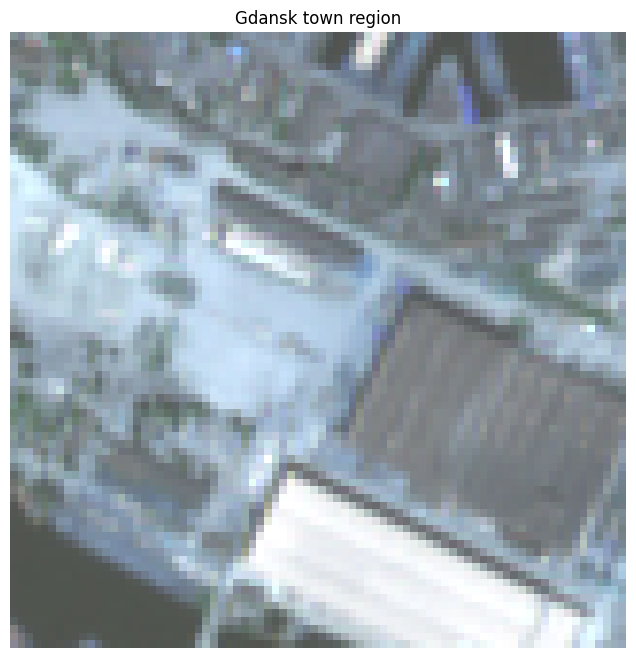

In [27]:
band_paths = {
    "B04": "/content/T34UCF~2.JP2",  # Red
    "B03": "/content/T34UCF~3.JP2",  # Green
    "B02": "/content/T34UCF~4.JP2",  # Blue
}
print("Found bands:", band_paths)

lon, lat =    18.655327,54.368873


transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x, y = transformer.transform(lon, lat)
dx = 400
dy = 400
xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy

def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

b4_crop = read_crop(band_paths["B04"], (xmin, ymin, xmax, ymax))
b3_crop = read_crop(band_paths["B03"], (xmin, ymin, xmax, ymax))
b2_crop = read_crop(band_paths["B02"], (xmin, ymin, xmax, ymax))

rgb_crop = np.dstack((b4_crop, b3_crop, b2_crop)).astype(np.float32)
rgb_crop /= np.percentile(rgb_crop, 99)
rgb_crop_urban = np.clip(rgb_crop, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb_crop_urban)
plt.title("Gdansk town region")
plt.axis("off")
plt.show()

Found bands: {'B04': '/content/T34UCF~2.JP2', 'B03': '/content/T34UCF~3.JP2', 'B02': '/content/T34UCF~4.JP2'}


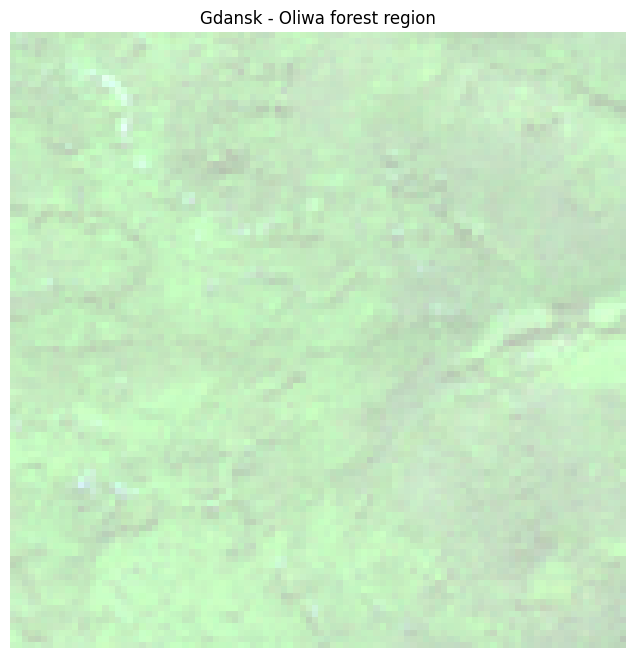

In [28]:
band_paths = {
    "B04": "/content/T34UCF~2.JP2",  # Red
    "B03": "/content/T34UCF~3.JP2",  # Green
    "B02": "/content/T34UCF~4.JP2",  # Blue
}
print("Found bands:", band_paths)

lon, lat =    18.550664,54.386205




transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x, y = transformer.transform(lon, lat)
dx = 500
dy = 500
xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy

def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

b4_crop = read_crop(band_paths["B04"], (xmin, ymin, xmax, ymax))
b3_crop = read_crop(band_paths["B03"], (xmin, ymin, xmax, ymax))
b2_crop = read_crop(band_paths["B02"], (xmin, ymin, xmax, ymax))

rgb_crop = np.dstack((b4_crop, b3_crop, b2_crop)).astype(np.float32)
rgb_crop /= np.percentile(rgb_crop, 99)
rgb_crop_forest = np.clip(rgb_crop, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb_crop_forest)
plt.title("Gdansk - Oliwa forest region")
plt.axis("off")
plt.show()

Found bands: {'B04': '/content/T34UCF~2.JP2', 'B03': '/content/T34UCF~3.JP2', 'B02': '/content/T34UCF~4.JP2'}


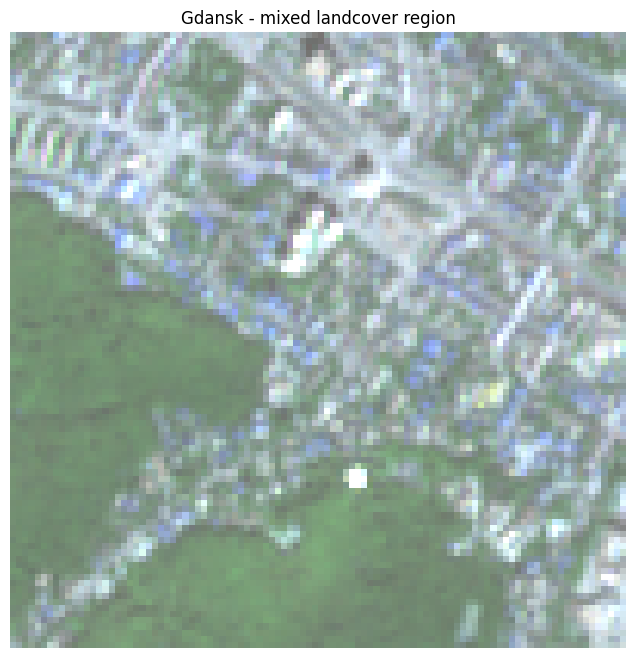

In [35]:
band_paths = {
    "B04": "/content/T34UCF~2.JP2",  # Red
    "B03": "/content/T34UCF~3.JP2",  # Green
    "B02": "/content/T34UCF~4.JP2",  # Blue
}
print("Found bands:", band_paths)

lon, lat =     18.605354,54.375523

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x, y = transformer.transform(lon, lat)
dx = 500
dy = 500
xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy

def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

b4_crop = read_crop(band_paths["B04"], (xmin, ymin, xmax, ymax))
b3_crop = read_crop(band_paths["B03"], (xmin, ymin, xmax, ymax))
b2_crop = read_crop(band_paths["B02"], (xmin, ymin, xmax, ymax))

rgb_crop = np.dstack((b4_crop, b3_crop, b2_crop)).astype(np.float32)
rgb_crop /= np.percentile(rgb_crop, 99)
rgb_crop_mix = np.clip(rgb_crop, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb_crop_mix)
plt.title("Gdansk - mixed landcover region")
plt.axis("off")
plt.show()

2. Bayes classifier -> histograms, code from previous labs

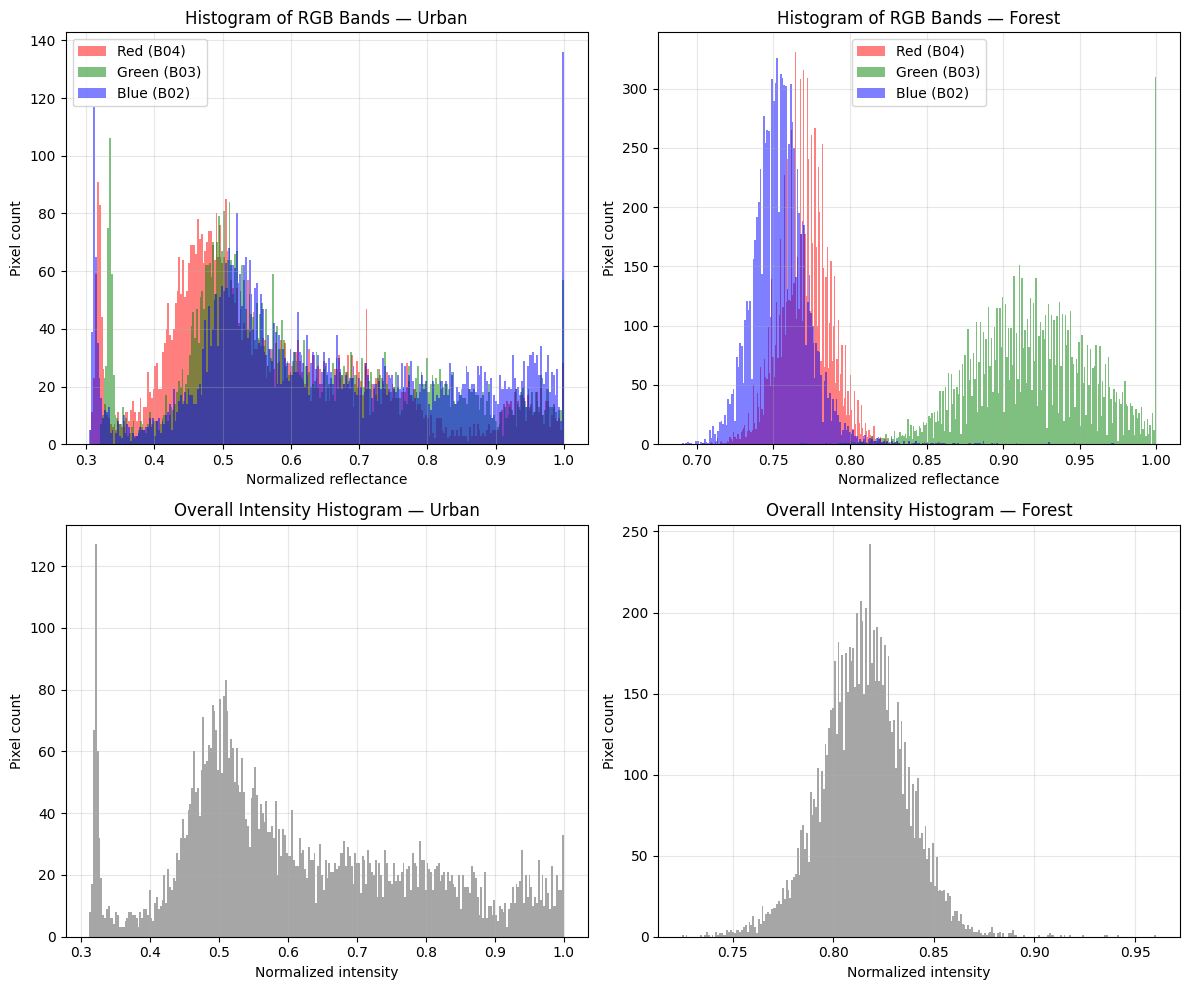

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def extract_bands_and_intensity(image):
    r, g, b = [image[:, :, i].ravel() for i in range(3)]
    mask = np.isfinite(r) & np.isfinite(g) & np.isfinite(b)
    r, g, b = r[mask], g[mask], b[mask]
    intensity = np.mean(image, axis=2).ravel()[mask]

    return r, g, b, intensity

r_u, g_u, b_u, i_u = extract_bands_and_intensity(rgb_crop_urban)
r_f, g_f, b_f, i_f = extract_bands_and_intensity(rgb_crop_forest)


def plot_rgb_hist(ax, r, g, b, title):
    ax.hist(r, bins=256, color='red', alpha=0.5, label='Red (B04)')
    ax.hist(g, bins=256, color='green', alpha=0.5, label='Green (B03)')
    ax.hist(b, bins=256, color='blue', alpha=0.5, label='Blue (B02)')
    ax.set_title(title)
    ax.set_xlabel("Normalized reflectance")
    ax.set_ylabel("Pixel count")
    ax.grid(alpha=0.3)
    ax.legend()

def plot_intensity_hist(ax, intensity, title):
    ax.hist(intensity, bins=256, color='gray', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Normalized intensity")
    ax.set_ylabel("Pixel count")
    ax.grid(alpha=0.3)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_rgb_hist(axes[0, 0], r_u, g_u, b_u, "Histogram of RGB Bands — Urban")
plot_rgb_hist(axes[0, 1], r_f, g_f, b_f, "Histogram of RGB Bands — Forest")
plot_intensity_hist(axes[1, 0], i_u, "Overall Intensity Histogram — Urban")
plot_intensity_hist(axes[1, 1], i_f, "Overall Intensity Histogram — Forest")

plt.tight_layout()
plt.show()


The code fits a one-inflated Beta model to the R, G, and B values of urban and forest areas, estimating how each color behaves in both classes. Then it computes, for every pixel, which class its colors are more likely under this model and labels it accordingly. The result is shown as a red-and-blue overlay: red for urban, blue for forest.

One-inflated Beta parameters (pi, alpha, beta):

Urban:
  R: pi=0.003, alpha=4.74, beta=3.62
  G: pi=0.008, alpha=4.46, beta=2.77
  B: pi=0.019, alpha=3.76, beta=2.03

Forest:
  R: pi=0.000, alpha=461.08, beta=137.25
  G: pi=0.030, alpha=49.23, beta=4.46
  B: pi=0.000, alpha=396.72, beta=128.55


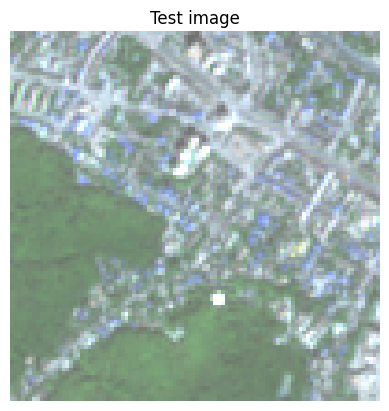

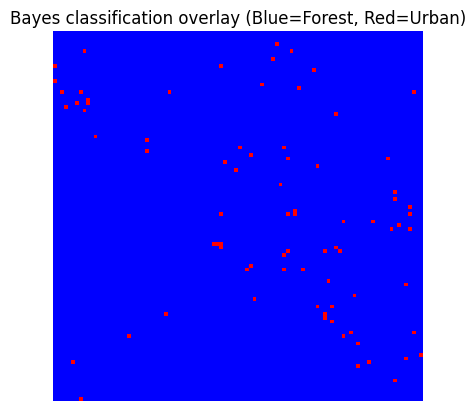

In [40]:
def fit_oib(x, eps=1e-6):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    x = np.clip(x, 0, 1)
    pi = np.mean(x >= 1 - eps)
    xc = x[(x > eps) & (x < 1 - eps)]
    if xc.size < 3: return pi, 1, 1
    m, v = np.mean(xc), np.var(xc)
    if v <= 0: return pi, 1, 1
    t = (m * (1 - m) / v) - 1
    if not np.isfinite(t) or t <= 0: return pi, 1, 1
    a, b = m * t, (1 - m) * t
    if any(k <= 0 or not np.isfinite(k) for k in (a, b)): return pi, 1, 1
    return pi, a, b

def lpdf_beta(x, a, b):
    lgB = math.lgamma(a) + math.lgamma(b) - math.lgamma(a + b)
    return (a - 1) * np.log(x) + (b - 1) * np.log(1 - x) - lgB

def lpdf_oib(x, pi, a, b, eps=1e-6):
    x = np.clip(np.asarray(x), 0, 1)
    c = x < 1 - eps
    out = np.empty_like(x, float)
    xs = np.clip(x[c], 1e-12, 1 - 1e-12)
    out[c] = np.log(max(1 - pi, 1e-12)) + lpdf_beta(xs, a, b)
    out[~c] = np.log(max(pi, 1e-12))
    return out

params_u = {k: fit_oib(v) for k, v in zip("RGB", (r_u, g_u, b_u))}
params_f = {k: fit_oib(v) for k, v in zip("RGB", (r_f, g_f, b_f))}

def classify(img, pf, pu, pf_prior=0.5, pu_prior=0.5, eps=1e-6):
    img = np.clip(img, 0, 1)
    r, g, b = img[..., 0], img[..., 1], img[..., 2]
    llf = sum(lpdf_oib(c, *pf[ch], eps) for c, ch in zip((r, g, b), "RGB")) + np.log(pf_prior + 1e-12)
    llu = sum(lpdf_oib(c, *pu[ch], eps) for c, ch in zip((r, g, b), "RGB")) + np.log(pu_prior + 1e-12)
    return llf > llu

test_img = np.array(rgb_crop_mix, float)
mask = classify(test_img, params_f, params_u)
overlay = np.zeros_like(test_img)
overlay[..., 0] = mask.astype(np.uint8) * 255
overlay[..., 2] = (~mask).astype(np.uint8) * 255

print("One-inflated Beta parameters (pi, alpha, beta):\n")
print("Urban:")
for k, v in params_u.items():
    print(f"  {k}: pi={v[0]:.3f}, alpha={v[1]:.2f}, beta={v[2]:.2f}")
print("\nForest:")
for k, v in params_f.items():
    print(f"  {k}: pi={v[0]:.3f}, alpha={v[1]:.2f}, beta={v[2]:.2f}")

plt.figure(); plt.imshow(test_img); plt.axis('off'); plt.title("Test image")
plt.figure(); plt.imshow(overlay.astype(np.uint8)); plt.axis('off'); plt.title("Bayes classification overlay (Blue=Forest, Red=Urban)")
plt.show()

The fitted PDFs show that forest areas are brighter and more consistent in green and blue, while urban areas are darker and more varied, with only a small spike at full reflectance. The classification overlay reflects this: vegetation shows as blue (forest) and built-up zones as red (urban). Some thin red edges and small noise near boundaries come from pixel-level Bayes decisions and mixed or shadowed pixels. Water shows up blue since only two classes were modeled, and it resembles forest more than urban in color. In summary - we cannot se much from this classification, a lot of urban areas are not shown.

kNN

The code samples random pixels from each RGB crop, labels them as forest or urban, and builds a small training set. It then flattens the test image and classifies each pixel using k-nearest neighbors, comparing its color to the training samples. The process runs for k=1, 3, and 5, and the results are shown as colored overlays for visualization.

In [41]:
def to_train(rgb, label, n):
    h, w, _ = rgb.shape
    flat = rgb.reshape(-1, 3)
    idx = np.random.default_rng(123).choice(flat.shape[0], size=min(n, flat.shape[0]), replace=False)
    X = flat[idx]
    y = np.full(X.shape[0], label, np.uint8)
    return X, y

N = 1500
X_u, y_u = to_train(rgb_crop_urban, 0, N)
X_f, y_f = to_train(rgb_crop_forest, 1, N)
X_train = np.vstack((X_u, X_f)).astype(np.float32)
y_train = np.concatenate((y_u, y_f))

test_img = np.array(rgb_crop_mix, float)
X_test = test_img.reshape(-1, 3).astype(np.float32)

def knn(Xt, yt, Xs, k=3, chunk=2048):
    n = Xs.shape[0]
    yp = np.empty(n, np.uint8)
    for i in range(0, n, chunk):
        j = min(i + chunk, n)
        T = Xs[i:j]
        d2 = np.sum((T[:, None, :] - Xt[None, :, :]) ** 2, 2)
        idx = np.argpartition(d2, k - 1, 1)[:, :k]
        labs = yt[idx]
        vf = np.sum(labs == 1, 1)
        yp[i:j] = (vf > k / 2).astype(np.uint8)
    return yp

results = {}
for k in (1, 3, 5):
    p = knn(X_train, y_train, X_test, k, 1024)
    results[k] = p.reshape(test_img.shape[:2]).astype(bool)

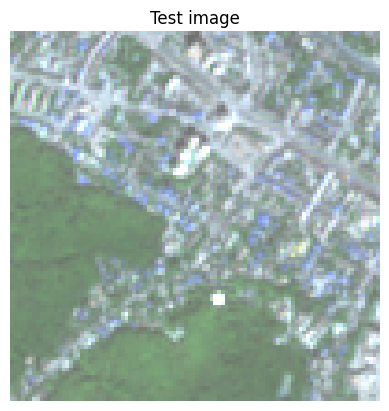

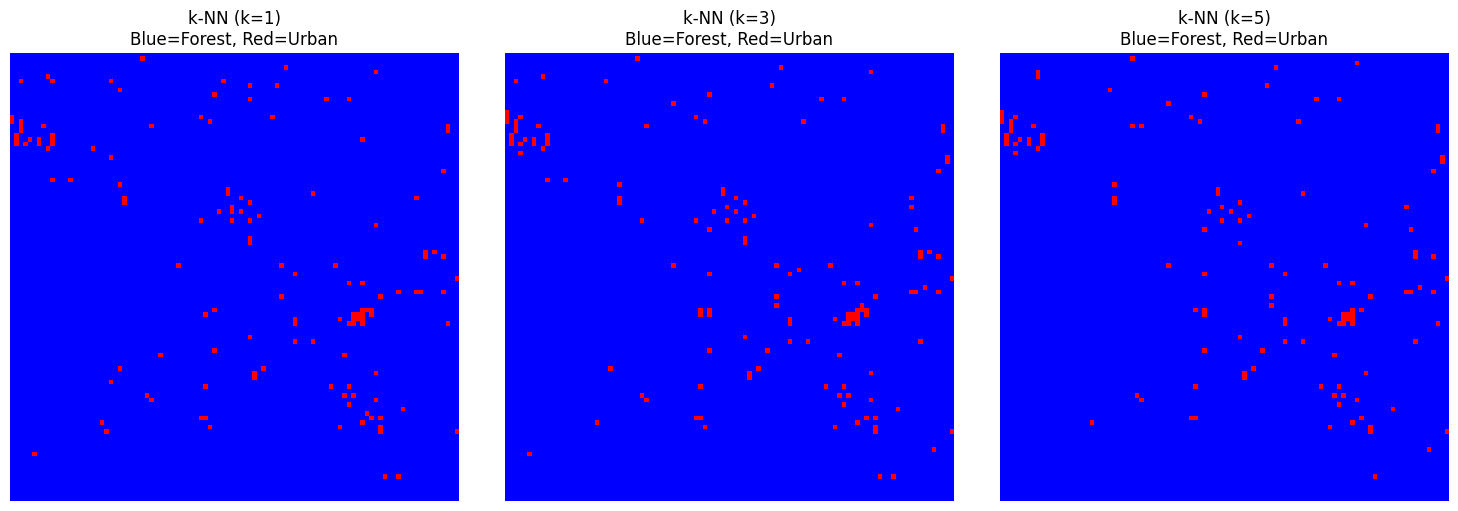

In [42]:
def make_overlay(mask):
    h, w = mask.shape
    o = np.zeros((h, w, 3), np.uint8)
    o[..., 2] = (~mask * 255).astype(np.uint8)
    o[..., 0] = (mask * 255).astype(np.uint8)
    return o

plt.figure(); plt.imshow(test_img); plt.axis('off'); plt.title("Test image")
ks = [1, 3, 5]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for a, k in zip(ax, ks):
    a.imshow(make_overlay(results[k]))
    a.axis('off')
    a.set_title(f"k-NN (k={k})\nBlue=Forest, Red=Urban")
plt.tight_layout(); plt.show()



Unfortunatelly, in my case, and in case of selected areas, classification doesnt seem to be working well. We cant tell much - only thing that is always true is that if pixel is red, it is almost 100% urban area. As k increases, the map gets smoother: k=1 is noisy with scattered pixels, k=3 cleans most of them while keeping detail, and k=5 gives the smoothest but slightly over-smoothed result, losing some fine urban features.
